# QR Codes Rotation

In [32]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
%matplotlib inline

# Crop QR from image

In this section, we'll read validation images and use their labels to crop QR's from image.

In [3]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [4]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'xmax', 'ymin', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
# Read validation data
xml_path = "data/valid/"
df = xml_to_csv(xml_path)
df

filename  width  height class  \
0   glare007_jpg.rf.2eb5b5dfde5ff0c3fd5dc4e5ebcbb7...    640     640  code   
1   glare007_jpg.rf.2eb5b5dfde5ff0c3fd5dc4e5ebcbb7...    640     640  code   
2   blurred033_jpg.rf.0972e12cd64a4b2d0710f9d1e4b0...    640     640  code   
3   blurred022_jpg.rf.c0d0e64aa4a91541a229b11e62b9...    640     640  code   
4   high001_jpg.rf.aff0ada1df871d4dcdd56409a968f60...    640     640  code   
..                                                ...    ...     ...   ...   
59  damaged008_jpg.rf.643437a1c052ba31fdafabd941a0...    640     640  code   
60  close010_jpg.rf.cbbb881a28ca69181f0082d2661d39...    640     640  code   
61  brightness005_jpg.rf.1227a4978b4dfa079542f5da5...    640     640  code   
62  brightness005_jpg.rf.1227a4978b4dfa079542f5da5...    640     640  code   
63  brightness005_jpg.rf.1227a4978b4dfa079542f5da5...    640     640  code   

    xmin  xmax  ymin  ymax  
0     55   241   109   315  
1    359   574   261   554  
2    148   436   217   440  
3     95   527   201   526  
4     24   603    27   575  
..   ...   ...   ...   ...  
59   151   406   208   424  
60    16   603   122   553  
61   459   536   272   330  
62   157   321   265   385  
63   411   503   378   445  

[64 rows x 8 columns]

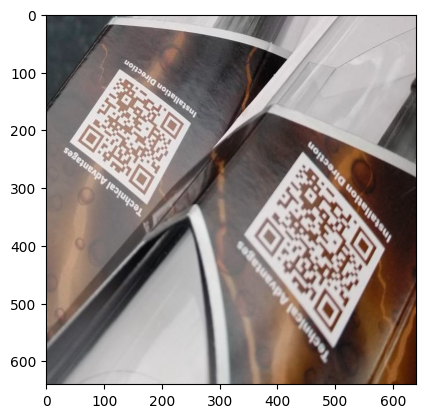

In [6]:
index = 1
filename = os.path.join(xml_path, df.filename[index])
image = cv2.imread(filename)
plt.imshow(image)

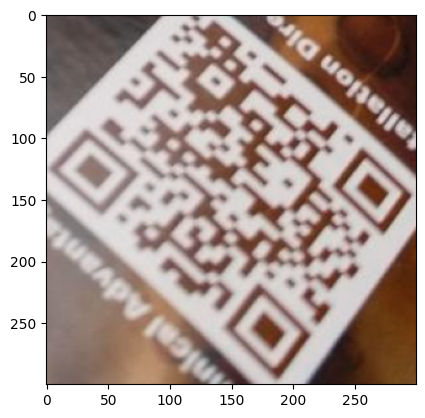

In [7]:
qr = image[df.ymin[index]:df.ymax[index], df.xmin[index]:df.xmax[index]]
qr = cv2.resize(qr, (300, 300))

plt.imshow(qr)

# Preprocess

In this step various techniques were analyzed in order to get the best image to obtain edges.

In [8]:
def equalization_clahe(img_gray, rgb=False):
    """Equalization using CLAHE
    Args:
        img_gray (np.array): 2 dimensional array
        rgb (bool): Flag if RGB array

    Returns:
        image CLAHE applied

    """
    if rgb:
        img_gray = cv2.cvtColor(img_gray, cv2.COLOR_RGB2GRAY)

    img_gray = cv2.GaussianBlur(img_gray, (21, 21), 1)
    img_gray = np.uint8(img_gray)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(7, 7))
    return clahe.apply(img_gray)


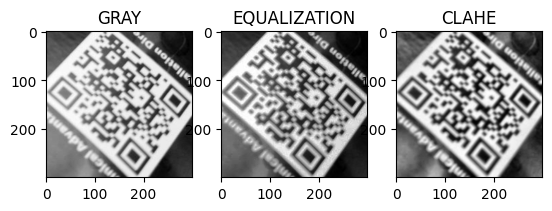

In [9]:
image_gray = cv2.cvtColor(qr, cv2.COLOR_BGR2GRAY)
image_clahe = equalization_clahe(image_gray)
image_eq = cv2.equalizeHist(image_gray)

fig, axs = plt.subplots(1, 3)
axs[0].set_title("GRAY")
axs[0].imshow(image_gray, cmap='gray')
axs[1].set_title("EQUALIZATION")
axs[1].imshow(image_eq, cmap='gray')
axs[2].set_title("CLAHE")
axs[2].imshow(image_clahe, cmap='gray')


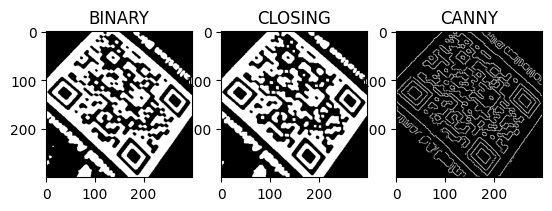

In [10]:
binary = cv2.threshold(image_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

kernel = np.ones((3,3),np.uint8)

closing = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations = 2)

edged = cv2.Canny(image_clahe, 0, 255)

fig, axs = plt.subplots(1, 3)
axs[0].set_title("BINARY")
axs[0].imshow(binary, cmap='gray')
axs[1].set_title("CLOSING")
axs[1].imshow(closing, cmap='gray')
axs[2].set_title("CANNY")
axs[2].imshow(edged, cmap='gray')


What worked the best was to apply CLAHE with a kernel of 8x8. Then binarization using OTSU method. Finally apply canny edge detector. We proceed to create a preprocess function.

In [11]:
def preproceess(image):
    """Binarizes image
    Args:
        image (np.array): dimensional array in BGR

    Returns:
        image binary image
    """
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_clahe = equalization_clahe(image_gray)
    binary = cv2.threshold(image_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    return binary
    

def detect_edges(image):
    """Performs canny edge detector
    Args:
        image (np.array): 2 dimensional array
        rgb (bool): Flag if RGB array

    Returns:
        edged (np.array): image containing edges
    """
    # in this case Hysteresis thresholds are ignored
    # beacuse a binary image is received
    edged = cv2.Canny(image, 0, 255)
    
    return edged

# Detect Finder Patterns

A QR finder pattern corresponds to a corner square. The very first step is to find contours, then aproximate them into a 4 sides figure.

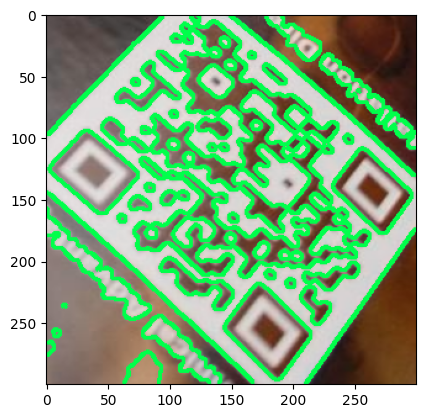

In [12]:
binary = preproceess(qr)
edged = detect_edges(binary)

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)

image_contours = cv2.drawContours(qr.copy(), contours, -1, (0,255,75), 2)
plt.imshow(image_contours)

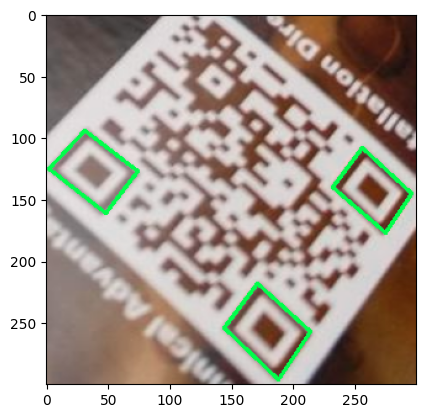

In [13]:
# loop over the contours
list_squares = []
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.025 * peri, True)

    if len(approx) == 4:
        area = cv2.contourArea(approx)
        if area > 100 and area < 10000:
            list_squares.append(approx)

list_squares = sorted(list_squares, key = cv2.contourArea, reverse = True)[:3]

# show the contour (outline) of the piece of paper
image_contours = cv2.drawContours(qr.copy(), list_squares, -1, (0,255,75), 2)
plt.imshow(image_contours)

In [14]:
def detect_finder_patterns(edged):
    
    """Edged image
    Args:
        edged (np.array): 2 dimensional array

    Returns:
        list_patterns (np.array): Array of 3 elements containing the 3
                        finder patterns. None if less than 3 patterns found.
    """
    
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    
    list_patterns = []
    for c in contours:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.025 * peri, True)

        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 100 and area < 10000:
                list_patterns.append(approx)

    list_patterns = sorted(list_patterns, key = cv2.contourArea, reverse = True)[:3]
    
    if len(list_patterns) < 3:
        return None
        
    return list_patterns

# Rotate QR

The final step is to correct the orientation.

In [15]:
binary = preproceess(qr)
edged = detect_edges(binary)
finder_patterns = detect_finder_patterns(edged)

We firstly calvulate the center of each pattern

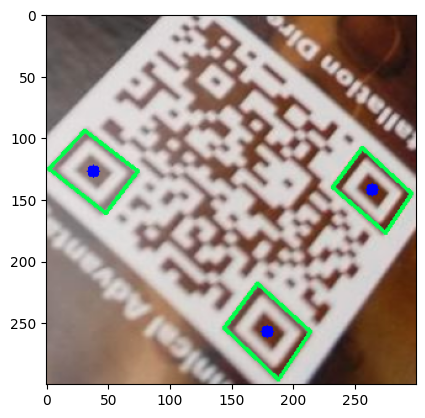

In [16]:
image_contours = cv2.drawContours(qr.copy(), finder_patterns, -1, (0,255,75), 2)

# Find square center
points = []
for square in list_squares:
    xmin = min(square[:,:,0])[0]
    xmax = max(square[:,:,0])[0]
    
    ymin = min(square[:,:,1])[0]
    ymax = max(square[:,:,1])[0]
    
    point = np.array((xmin + (xmax-xmin)//2, ymin + (ymax-ymin)//2))
    points.append(point)
    
    # Draw center point
    image = cv2.circle(image_contours, point, radius=5, color=(0, 0, 255), thickness=-1)

plt.imshow(image_contours)

Finder Patterns are composed of 3 squares located as follows: North West, North East, South West. We must rotate the image in order to get the same 3 referenced squares.

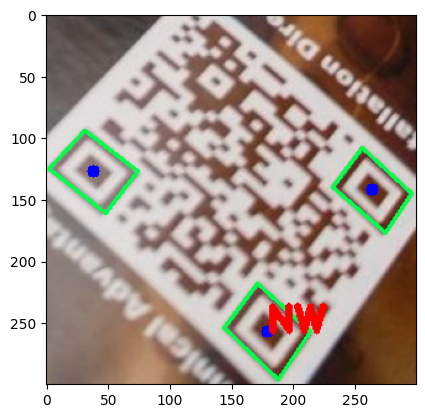

In [17]:
# Find North West finder pattern (left upper corner)
# This has the shortest distance to the 2 remaining squares
distances = [0,0,0]

dist1 = np.linalg.norm(points[0]-points[1])
dist2 = np.linalg.norm(points[0]-points[2])
dist3 = np.linalg.norm(points[1]-points[2])

distances[0] = dist1+dist2
distances[1] = dist1+dist3
distances[2] = dist2+dist3

index_nw = np.argmin(distances)

image_nw = image_contours.copy()
cv2.putText(img=image_nw, text="NW",org=points[index_nw], fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1, color=(255,0,0), thickness=3)
plt.imshow(image_nw)

Now we calculate the rotation angle to get the NW pattern to the right location.

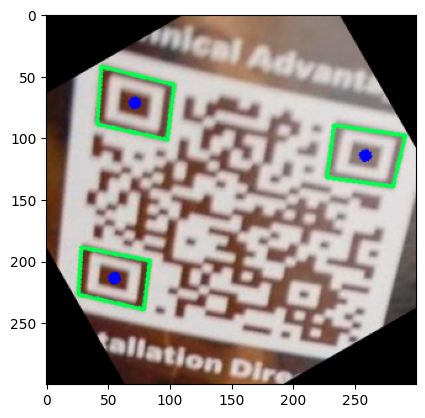

In [18]:
# Reference point
ref_point = [0,0]
center_image = np.array(image_contours.shape[:2])//2
angle_ref = -np.arctan2(ref_point[0]-center_image[0], ref_point[1]-center_image[1]) * 180/np.pi

# Angle to nw point
nw_point = points[index_nw]
nw_angle = -np.arctan2(nw_point[0]-center_image[0], nw_point[1]-center_image[1]) * 180/np.pi
rotation_angle = nw_angle - angle_ref

# Find Rotation Matrix
(h, w) = image_contours.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), rotation_angle, 1.0)

rotated = cv2.warpAffine(image_contours, M, (w, h))
plt.imshow(rotated)

In [19]:
points

[array([179, 257]), array([ 38, 127]), array([264, 142])]

It seems that we have not really corrected the orientation. So here it is, the final step. We take the North East pattern and find the final correction.

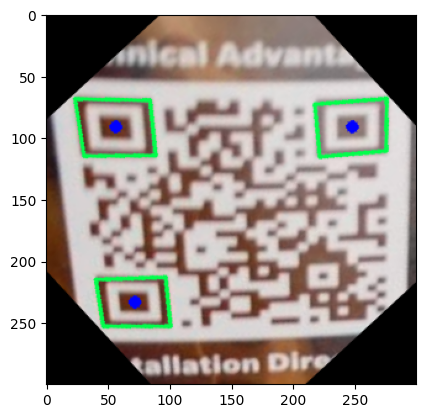

In [20]:
# Remember that the list of patterns is according to the 
# image previous rotation. We must firstly rotate them.

# Transform center points
transformed_points = []
for point in points:
    np_point = np.array([point[0], point[1], 1])
    transformed_points.append(np.dot(M, np_point))

# Calculate Correction Anlge

# Get North West point
nw_point = transformed_points.pop(index_nw)

index_ne = 0
if transformed_points[1][0] > transformed_points[0][0]:
    index_ne = 1

# Get North East point
ne_point = transformed_points.pop(index_ne)

# Get Correction Angle
correction_angle = np.arctan2(ne_point[1]-nw_point[1], ne_point[0]-nw_point[0]) * 180/np.pi

# Compute corrected image
M = cv2.getRotationMatrix2D((cX, cY), rotation_angle+correction_angle, 1.0)
rotated = cv2.warpAffine(image_contours, M, (w, h))
plt.imshow(rotated)

We proceed to rewrite the steps into functions.

In [21]:
def find_pattern_points(list_squares):
    # Find square center
    points = []
    for square in list_squares:
        xmin = min(square[:,:,0])[0]
        xmax = max(square[:,:,0])[0]

        ymin = min(square[:,:,1])[0]
        ymax = max(square[:,:,1])[0]

        point = np.array((xmin + (xmax-xmin)//2, ymin + (ymax-ymin)//2))
        points.append(point)
        
    return points


def find_nw_pattern(points):
    distances = [0,0,0]

    dist1 = np.linalg.norm(points[0]-points[1])
    dist2 = np.linalg.norm(points[0]-points[2])
    dist3 = np.linalg.norm(points[1]-points[2])

    distances[0] = dist1+dist2
    distances[1] = dist1+dist3
    distances[2] = dist2+dist3

    index_nw = np.argmin(distances)
    
    return index_nw

def calculate_nw_rotation(nw_pattern, image_shape):
    # Reference point
    ref_point = [0,0]
    center_image = np.array(image_shape)//2
    angle_ref = -np.arctan2(ref_point[0]-center_image[0], ref_point[1]-center_image[1]) * 180/np.pi

    # Angle to nw point
    nw_point = nw_pattern
    nw_angle = -np.arctan2(nw_point[0]-center_image[0], nw_point[1]-center_image[1]) * 180/np.pi
    rotation_angle = nw_angle - angle_ref

    # Find Rotation Matrix
    (h, w) = image_shape
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), rotation_angle, 1.0)
    
    return M, rotation_angle

def calculate_correction_angle(points, image_shape):
    
    index_nw = find_nw_pattern(points)
    M, rotation_angle = calculate_nw_rotation(points[index_nw], image_shape)
    
    # Transform center points
    transformed_points = []
    for point in points:
        np_point = np.array([point[0], point[1], 1])
        transformed_points.append(np.dot(M, np_point))
    
    # Calculate Correction Anlge
    # Get North West point
    nw_point = transformed_points.pop(index_nw)

    index_ne = 0
    if transformed_points[1][0] > transformed_points[0][0]:
        index_ne = 1

    # Get North East point
    ne_point = transformed_points.pop(index_ne)

    # Get Correction Angle
    correction_angle = np.arctan2(ne_point[1]-nw_point[1], ne_point[0]-nw_point[0]) * 180/np.pi
    
    return rotation_angle+correction_angle

def rotate_image(image, angle):
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    
    return rotated

# Pipeline

In [22]:
def pipeline(qr):
    
    binary = preproceess(qr)
    edged = detect_edges(binary)
    image_shape = edged.shape[:2]

    finder_patterns = detect_finder_patterns(edged)
    
    if not finder_patterns:
        return qr

    points = find_pattern_points(finder_patterns)
    angle = calculate_correction_angle(points, image_shape)

    return rotate_image(qr, angle)

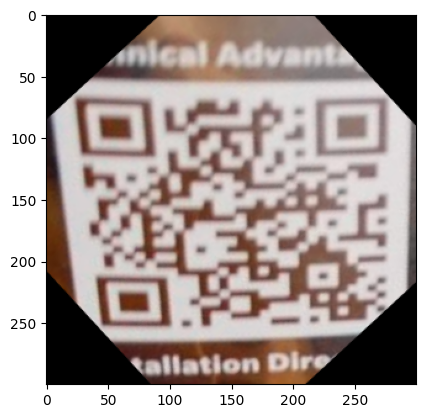

In [23]:
rotated_image = pipeline(qr)
plt.imshow(rotated_image)

# Test on Validation images

In [24]:
def plot_gallery(images, n_row=6, n_col=3):
    """Helper function to plot a gallery of traffic signs"""
    plt.figure(figsize=(3.5 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0, right=1.1, top=1)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.xticks(())
        plt.yticks(())

In [25]:
rotated_images = []
for index in range(26):
    
    filename = os.path.join(xml_path, df.filename[index])
    image = cv2.imread(filename)

    # Crop QR
    delta = 0
    qr = image[df.ymin[index] - delta:df.ymax[index]+delta, df.xmin[index]-delta:df.xmax[index]+delta]
    qr = cv2.resize(qr, (300, 300))

    rotated_image = pipeline(qr)
    
    # Stack images
    res = np.hstack((qr, rotated_image))

    rotated_images.append(res)


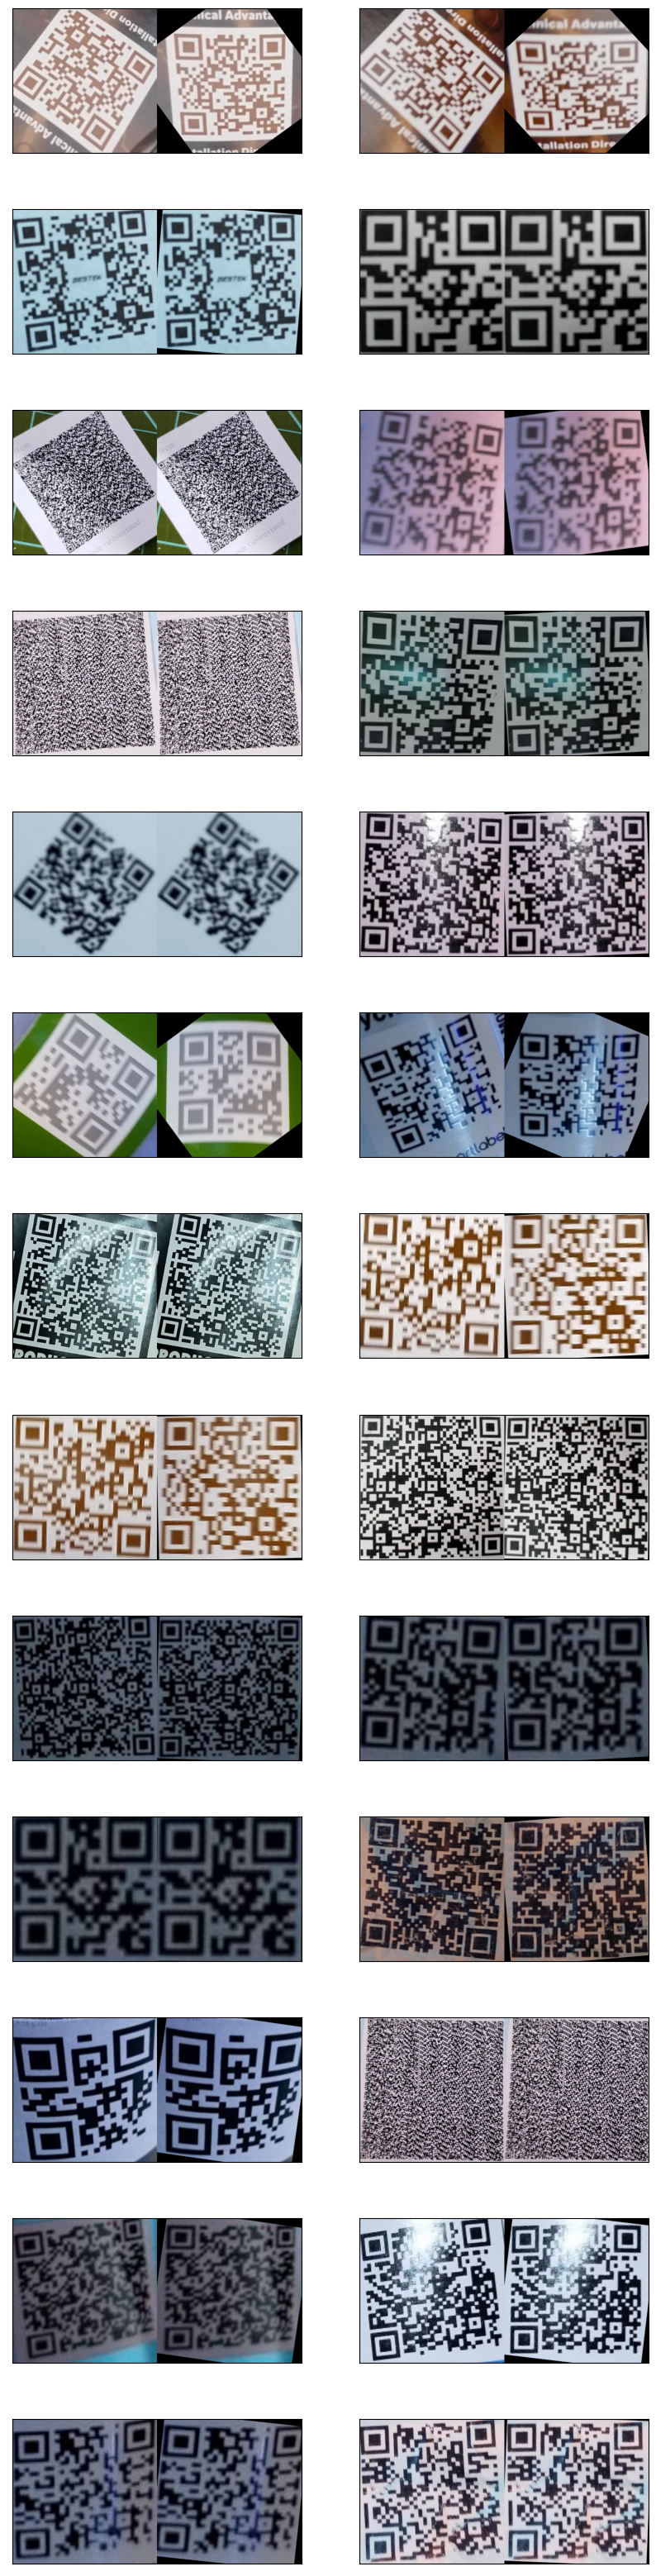

In [26]:
plot_gallery(rotated_images,13,2)